In [2]:
from __future__ import annotations

import time
from dataclasses import asdict, dataclass
from pathlib import Path
from typing import Literal

import jax
import jax.numpy as jnp
import liesel.goose as gs
import numpy as np
import optax
import pandas as pd
import torch
import veccs
from batram.legmods import Data, SimpleTM
from batram.stopper import EarlyStopper

import ppptm as gptm

torch.set_default_dtype(torch.float64)
jax.config.update("jax_enable_x64", True)

In [ ]:
# ----------------------------------------------------------------------------------
# Data import
# ----------------------------------------------------------------------------------

data = gptm.load_americas()

shuffle_loc_indices = jax.random.permutation(
    jax.random.key(1), jnp.arange(data.locs.shape[0])
)

locs = data.locs[shuffle_loc_indices, ...]
y = data.obs[..., shuffle_loc_indices]


## Aritificial data partition for demo purposes

In [23]:
locs_obs = locs[:275, ...]
y_obs = y[..., :275]
print(locs_obs.shape)
print(y_obs.shape)

(275, 2)
(98, 275)


In [24]:
locs_rcm = locs[275:, ...]
y_rcm = y[..., 275:]
print(locs_rcm.shape)
print(y_rcm.shape)

(2463, 2)
(98, 2463)


## Pooling the data

In [25]:
locs_all = jnp.concatenate((locs_obs, locs_rcm))
y_all = jnp.concatenate((y_obs, y_rcm), axis=1)
print(locs_all.shape)
print(y_all.shape)

(2738, 2)
(98, 2738)


In [26]:
locs_object = gptm.Locations(
    unordered=locs_all,
    ordering=jnp.arange(locs_all.shape[0]),  # no maximin ordering
    n_subset=locs_obs.shape[0],  # number of locs in locs_obs is used
)
locs_var = gptm.LocationVars(locs_object)

print(jnp.allclose(locs_var.ordered_subset.value, locs_obs))
print(jnp.allclose(locs_var.ordered.value, locs_all))

True
True


## Model fitting

In [27]:
# ----------------------------------------------------------------------------------
# Marginal model
# ----------------------------------------------------------------------------------

# set up G
G = gptm.G(y_all, locs_var, ard=False)
g = G.new_gaussian()
locscale = True


# set up H
h = gptm.H(
    locs_var,
    ard=False,
    locwise_amplitude=True,
).new_coef()

# set up model
marginal_model = gptm.Model.new_HG(
    y_all,
    locs_var,
    g_dist=g,
    coef=h,
    locscale=locscale,
    a=-4.0,
    b=4.0,
    nparam=40,
)


# fit model
scheduler = optax.cosine_decay_schedule(init_value=0.01, decay_steps=1000)
hg_opt = optax.adamw(learning_rate=scheduler, weight_decay=1e-4)
gradient_clipping = optax.clip_by_global_norm(1.0)
marginal_opt = optax.chain(gradient_clipping, hg_opt)

start = time.time()
result = marginal_model.fit(
    stopper=gs.Stopper(max_iter=1000, patience=10, atol=0.3),
    response_validation=y_all,  # using training data for early stopping here
    optimizer=marginal_opt,
    progress_bar=True,
)
end = time.time()
time_hg = end - start


Training loss: 423260.042, Validation loss: 423260.042:  25%|██▌       | 251/1000 [00:22<01:02, 12.03it/s] 

In [31]:
hg_all = marginal_model.hg(y_all)
hg_rcm = hg_all[..., 275:]
print(hg_rcm.shape)

(98, 2463)


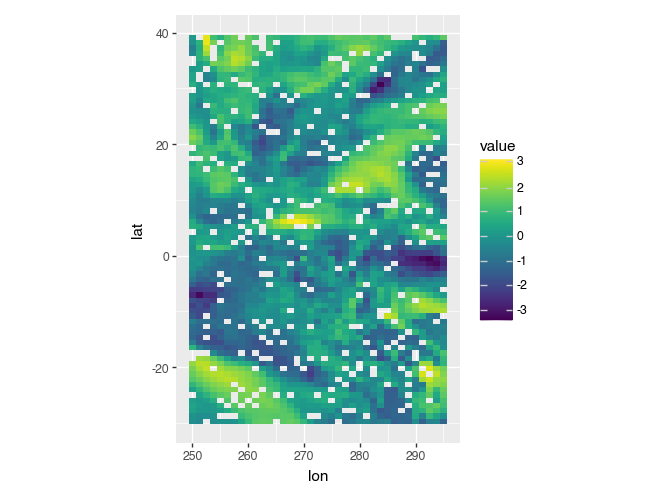

In [32]:
# plot of training data at all locations
hg_rcm_df = gptm.long_df(locs_rcm, hg_rcm)
gptm.plot_df(hg_rcm_df.query("obs == 5"))

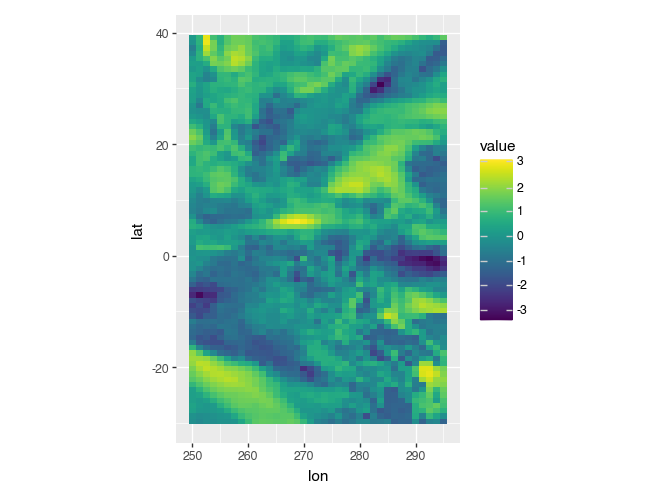

In [33]:
# plot of training data at all locations
hg_all_df = gptm.long_df(locs_all, hg_all)
gptm.plot_df(hg_all_df.query("obs == 5"))

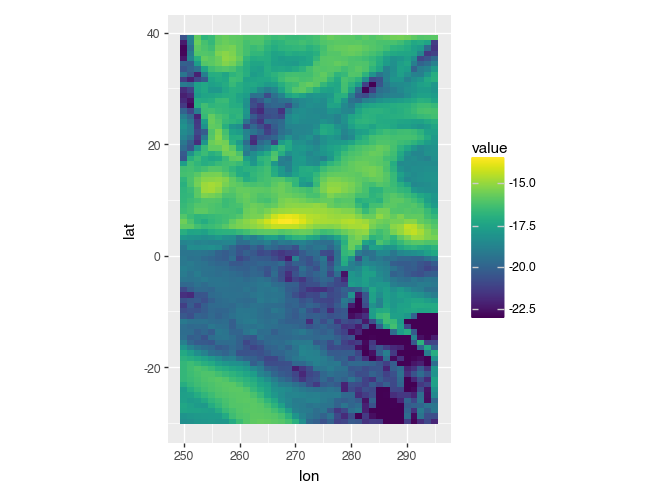

In [34]:
# plot of training data at all locations
y_all_df = gptm.long_df(locs_all, y_all)
gptm.plot_df(y_all_df.query("obs == 5"))